In [3]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

def load_save_and_get_horizons(model_name,target_data,p,dataset_names):
    id_name = f"{target_data}_{model_name}.{'_'.join(dataset_names)}_{p}p"
    # folder_path = os.path.join(f'save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_{model_name}',f'{target_data}_{p}p')
    try: 
        folder_path = os.path.join(f'save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_{model_name}',id_name)
        results = pd.read_csv(f'{folder_path}/METRICS_{id_name}.csv',index_col = 0)
    except:
        folder_path = os.path.join(f'../save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_{model_name}',id_name)
        results = pd.read_csv(f'{folder_path}/METRICS_{id_name}.csv',index_col = 0)

    mae_metrics = [c for c in results.columns if ('mae' in c) and (not 'VAR' in c) and not ('complete' in c)]
    mae_metrics  = [int(c.split('h')[-1]) for c in mae_metrics]
    horizon_max = int(np.max(np.array(mae_metrics)))
    return results,horizon_max


def plot_accuracy_according_size(model_names,dic_dataset_names,metrics,
                                target_data,percentage_list,dic_colors,dic_linestyle,
                                horizon_list = None):

    # == Init
    for model_name in model_names:
        for dataset_names in dic_dataset_names[model_name]:
            for metric in metrics:
                _,horizon_max = load_save_and_get_horizons(model_name,target_data,100,dataset_names)
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list"] = []
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h1"] = []
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max//2}"] = []
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max}"] = []
    # ...

    for model_name in model_names:
        for dataset_names in dic_dataset_names[model_name]:
            #== Fill List: 
            for p in percentage_list:
                # build list of metrics for each percentage
                results,horizon_max = load_save_and_get_horizons(model_name,target_data,p,dataset_names)

                for metric in metrics:
                    selected_columns = [c for c in results.columns if (c.startswith(metric)) and not 'complete' in c]
                    metric_all = results[selected_columns].mean(axis=1)['test']
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list"].append(metric_all)
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h1"].append(results[selected_columns][f"{metric}_h1"]['test'])
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max//2}"].append(results[selected_columns][f"{metric}_h{horizon_max//2}"]['test'])
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max}"].append(results[selected_columns][f"{metric}_h{horizon_max}"]['test'])
                # ...
                
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list"] for metric in metrics})
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h1"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h1"] for metric in metrics})
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max//2}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max//2}"] for metric in metrics})
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max}"] for metric in metrics})

            globals()[f"df_{model_name}_{'_'.join(dataset_names)}"].index = percentage_list
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h1"].index = percentage_list
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max//2}"].index = percentage_list
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max}"].index = percentage_list
            # ...

    if horizon_list is None:
        horizon_list = [''] + [f'_h{h}' for h in [1,horizon_max//2,horizon_max]]

    
    for horizon in horizon_list:
        fig, axes = plt.subplots(1,len(metrics),figsize=(22, 5))
        for k,metric in enumerate(metrics): 
            for model_name in model_names:
                for dataset_names in dic_dataset_names[model_name]:
                    str_ds_names = '_'.join(dataset_names)
                    label_ds = [ds for ds in dataset_names if not ds == target_data]

                    if label_ds == []:
                        label = f"{model_name}"
                    else:
                        label_i = '\n'.join(label_ds)
                        label = f"{model_name} - {label_i}"
                        label = label.replace('_embedding', ' ')
                    
                    s = globals()[f"df_{model_name}_{str_ds_names}{horizon}"][metric]
                    axes[k].plot(s.index,
                                 s,
                                 label = label,
                                 color = dic_colors[model_name][str_ds_names],
                                 linestyle  = dic_linestyle[model_name][str_ds_names]
                                 )
            title = f"Comparison of {metric.upper()}\nbetween: {','.join(model_names)}\non {target_data} prediction\n"
            if horizon != '':
                title = f"{title}\n at horizon {horizon[2:]}"
            axes[k].set_title(title)
            axes[k].set_xlabel('Percentage total training data')
            axes[k].set_ylabel(metric.upper())
            #plt.xticks(range(len(percentage_list)), percentage_list)
            plt.ylabel(metric)
            plt.xlabel('Percentage of Training Data')
            plt.legend()
            if False:
                if metric == 'mase':
                    axes[k].plot([np.min(np.array(percentage_list)), 100], [1, 1], color='red', linestyle='--', label='MASE = 1')
        # Display Legend outside of the plt.plot:
        plt.tight_layout()
        plt.subplots_adjust(right=0.85)
        plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5)) #  loc='lower center',bbox_to_anchor=(-1.2, -0.6)
        plt.show()

print('Current working directory: ',os.getcwd())

Current working directory:  /home/rrochas/prediction-validation


# Load Manhattan muti-modal datasets

In [ ]:
import os 
import glob 
import pandas as pd
import geopandas as gpd
from shapely import Point
from datetime import datetime
import pandas as pd
import numpy as np

FOLDER_PATH = '../../../../data/rrochas/raw_data/Manhattan'
SAVE_PATH = '../../../../data/rrochas/prediction_validation/Manhattan'

# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# Load city bike data: 
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
year = 2021
month = 1
bike_save_path  = f'{SAVE_PATH}/city_bike_{year}'
df_test = pd.read_csv(f'{bike_save_path}/{month:02d}_15min_emitted.csv',index_col=0,dtype={0: str} )  # specify first column as string



# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# Load Subway data: 
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# df_subway_4h = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Turnstile_Usage_Data__2021_20250812.csv',index_col=0)
df_subway_4h = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Turnstile_Usage_Data__2022_20250812.csv',index_col=0)

df_subway_4h.rename(columns={'Exits                                                     ': 'Exits'}, inplace=True)
gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)



# According to this medium url https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
# suppose to use the three one to get the spatial matching : 
if False: 
    subway_entry_exits = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Entrances_and_Exits__2024_20250813.csv',index_col=0)
    remote_df = pd.read_excel(f'{FOLDER_PATH}/Remote-Booth-Station.xls', index_col=0) 
    gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)


# But found this Kaggle dataset which has been already preprocessed and contains the station and matching with 'Unit':
# https://www.kaggle.com/datasets/eddeng/nyc-subway-traffic-data-20172021/data?select=station_lookup.csv
station_lookup = pd.read_csv(f'{FOLDER_PATH}/station_lookup.csv', index_col=0) 
gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)


# --- Merging : 
# Get correspondance : 
mask = ~station_lookup['complex_id'].isna()
station_lookup = station_lookup[mask].copy()
station_lookup['complex_id'] = station_lookup['complex_id'].astype(int)
station_lookup.rename(columns={'complex_id': 'Complex ID'}, inplace=True)

# Merge gdf : 
merged_gdf = gdf[['GTFS Stop', 'Station ID','Complex ID','Division', 'Line','Stop Name', 'geometry']].merge(station_lookup[['Complex ID', 'booth']].reset_index(), how='inner', on = 'Complex ID')
merged_gdf.rename(columns={'remote ': 'remote'}, inplace=True)

## Preprocessing of the 4-hours aggregated MTA datasets :

In [ ]:
# ---- Reduce df_subway_4h to only manhattan stations: 
reduced_df_subway_4h = df_subway_4h[df_subway_4h['Unit'].isin(merged_gdf['remote'])].copy()
reduced_df_subway_4h = reduced_df_subway_4h.reset_index()
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ---- Convert Date and Time to datetime:
reduced_df_subway_4h['Date']=reduced_df_subway_4h['Date'].str.strip()
reduced_df_subway_4h['Time']=reduced_df_subway_4h['Time'].str.strip()
reduced_df_subway_4h['Time'] = pd.to_datetime(reduced_df_subway_4h['Time']).dt.strftime('%H:%M:%S') # Convert Time HH:MM:SS AM or HH:MM:SS PM to HH:MM:SS format
datetime_str = reduced_df_subway_4h['Date'] + ' ' + reduced_df_subway_4h['Time']
coerced_dates = pd.to_datetime(datetime_str, errors='coerce')
mismatched_rows = reduced_df_subway_4h[coerced_dates.isna()]
assert len(mismatched_rows) == 0, f"There are {len(mismatched_rows)} rows with mismatched dates or times in the dataset."
reduced_df_subway_4h['datetime'] = coerced_dates
# ---- 
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ----  Get Net Entries and Exits:
# Get unique unit_id 
reduced_df_subway_4h['unit_id'] = reduced_df_subway_4h.apply(lambda row: f"{row['Unit']}_{row['C/A']}_{row['SCP']}",axis=1)

# Compute differences in Entries and Exits at each unique unit_id:
reduced_df_subway_4h.sort_values(by=['unit_id', 'datetime'], inplace=True)
reduced_df_subway_4h['Net_Entries'] = reduced_df_subway_4h.groupby('unit_id')['Entries'].diff()
reduced_df_subway_4h['Net_Exits'] = reduced_df_subway_4h.groupby('unit_id')['Exits'].diff()
reduced_df_subway_4h['Net_Flow'] = reduced_df_subway_4h['Net_Entries'] - reduced_df_subway_4h['Net_Exits']
# ---- 
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ---- Clean up the DataFrame by removing rows with Negatives values, too large time interval, or extreme outliers :
# Init 
abnormal_time_interval = 24 # hours 
flow_threshold = 15000  

# Tackle Negative Values 
init_df_shape = len(reduced_df_subway_4h)
df_cleaned = reduced_df_subway_4h[(reduced_df_subway_4h['Net_Entries'] >= 0) & (reduced_df_subway_4h['Net_Exits'] >= 0)].copy()
print(f"Pourcentage of Remaining rows after removing negative values : {len(df_cleaned)/init_df_shape:2f}%")

# Tackle Abnormal time intervales: 
df_cleaned['time_diff'] = df_cleaned.groupby('unit_id')['datetime'].diff()
time_threshold = pd.Timedelta(hours=abnormal_time_interval)
df_cleaned = df_cleaned[df_cleaned['time_diff'] <= time_threshold]
df_cleaned = df_cleaned.drop(columns=['time_diff'])
print(f"Pourcentage of Remaining rows after removing anormal time interval :  {len(df_cleaned)/init_df_shape:2f}%")

#Tackle Flow threshold:
df_cleaned = df_cleaned[(df_cleaned['Net_Entries'] < flow_threshold) &(df_cleaned['Net_Exits'] < flow_threshold)]
print(f"Pourcentage of Remaining rows after removing outliers:  {len(df_cleaned)/init_df_shape:2f}%")
# ----
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ---- Sum through all turnstiles: 
df_entries = df_cleaned.groupby(['Unit','datetime']).agg(Net_Entries=('Net_Entries', 'sum')).unstack(level=0)
df_entries.columns = df_entries.columns.droplevel(0)
df_exits = df_cleaned.groupby(['Unit','datetime']).agg(Net_Exits=('Net_Exits', 'sum')).unstack(level=0)
df_exits.columns = df_exits.columns.droplevel(0)
df_flows = df_cleaned.groupby(['Unit','datetime']).agg( Net_Flow=('Net_Flow', 'sum')).unstack(level=0)
df_flows.columns = df_flows.columns.droplevel(0)
# ----
# ----------------------------------------------------------------

/tmp/ipykernel_189990/3576513454.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reduced_df_subway_4h['Time'] = pd.to_datetime(reduced_df_subway_4h['Time']).dt.strftime('%H:%M:%S') # Convert Time HH:MM:SS AM or HH:MM:SS PM to HH:MM:SS format


## Now need to interpolate the 4 hours aggregated data into 1h aggregated data:

In [456]:
display(df_exits)
display(df_exits.resample('4h').sum())

Unit,R001,R010,R011,R012,R013,R014,R015,R016,R017,R020,...,R344,R345,R452,R453,R461,R462,R463,R570,R571,R572
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 08:00:00,284.0,NaN,NaN,NaN,NaN,290.0,NaN,NaN,NaN,NaN,...,NaN,NaN,517.0,NaN,253.0,123.0,216.0,344.0,170.0,211.0
2022-01-01 09:00:00,NaN,731.0,NaN,NaN,NaN,NaN,207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 11:00:00,NaN,NaN,1676.0,1307.0,811.0,NaN,NaN,107.0,524.0,1266.0,...,26.0,96.0,NaN,262.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 12:00:00,1169.0,NaN,NaN,NaN,NaN,1523.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1602.0,NaN,1120.0,502.0,1011.0,586.0,544.0,346.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 19:00:00,NaN,NaN,10367.0,9616.0,1903.0,NaN,NaN,1104.0,571.0,19106.0,...,69.0,923.0,NaN,2762.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30 20:00:00,4666.0,NaN,NaN,NaN,NaN,7000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,5832.0,NaN,6786.0,3260.0,3896.0,3353.0,3105.0,2295.0
2022-12-30 21:00:00,NaN,6804.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unit,R001,R010,R011,R012,R013,R014,R015,R016,R017,R020,...,R344,R345,R452,R453,R461,R462,R463,R570,R571,R572
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 08:00:00,284.0,731.0,1676.0,1307.0,811.0,290.0,207.0,107.0,524.0,1266.0,...,26.0,96.0,517.0,262.0,253.0,123.0,216.0,344.0,170.0,211.0
2022-01-01 12:00:00,1169.0,1533.0,2527.0,2455.0,1401.0,1523.0,1003.0,176.0,912.0,2350.0,...,43.0,164.0,1602.0,436.0,1120.0,502.0,1011.0,586.0,544.0,346.0
2022-01-01 16:00:00,1845.0,3004.0,3575.0,3002.0,2187.0,2439.0,1579.0,234.0,1027.0,3592.0,...,51.0,254.0,2619.0,693.0,2169.0,1215.0,2046.0,936.0,886.0,612.0
2022-01-01 20:00:00,1447.0,3522.0,2817.0,1575.0,952.0,2422.0,699.0,149.0,695.0,1352.0,...,32.0,185.0,2266.0,345.0,1597.0,1174.0,1586.0,1226.0,1365.0,1004.0
2022-01-02 00:00:00,917.0,1042.0,664.0,519.0,256.0,1247.0,148.0,82.0,248.0,324.0,...,13.0,104.0,1189.0,88.0,526.0,308.0,442.0,859.0,901.0,741.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 04:00:00,472.0,524.0,1096.0,1274.0,352.0,454.0,27.0,353.0,160.0,2385.0,...,20.0,66.0,408.0,445.0,235.0,88.0,138.0,308.0,467.0,471.0
2022-12-30 08:00:00,1013.0,2138.0,4218.0,4301.0,1367.0,2473.0,15.0,1326.0,645.0,12734.0,...,63.0,227.0,1780.0,1953.0,1167.0,544.0,615.0,2268.0,865.0,842.0
2022-12-30 12:00:00,5919.0,3808.0,5710.0,5911.0,2395.0,6242.0,25.0,845.0,443.0,14104.0,...,79.0,354.0,5244.0,2105.0,4764.0,2684.0,3651.0,4122.0,2256.0,1467.0


<Axes: xlabel='datetime'>

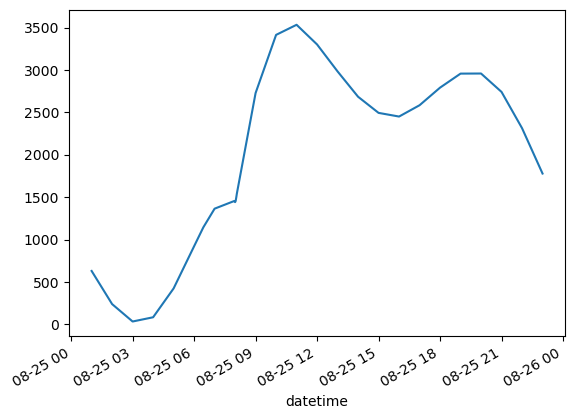

In [ ]:

df_interpolated = df_exits.copy()
df_interpolated = df_interpolated.interpolate(method='spline', order=3)
mean_df_interpolated = df_interpolated.mean(1)
mean_df_interpolated[(mean_df_interpolated.index > datetime(2022,8,25) )& (mean_df_interpolated.index < datetime(2022,8,26))].plot()

# Interpolation with CubicSpline: 

<Axes: >

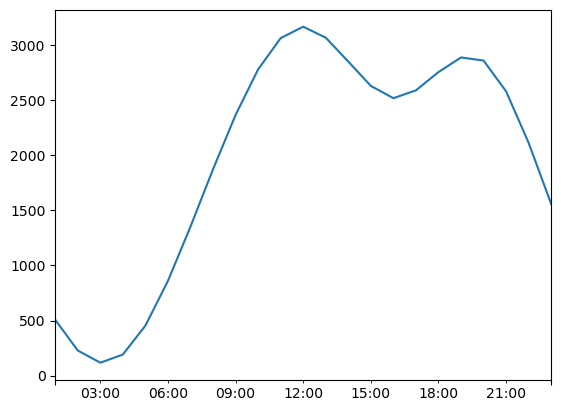

In [306]:
from scipy.interpolate import CubicSpline

y = df_exits.resample('4h').sum()
x = y.index

xs = pd.date_range(start=df_entries.index.min(), end=df_entries.index.max(), freq='1h')
cs = CubicSpline(x, y, axis=0)


#
mean_subway_checkout = pd.DataFrame(cs(xs),index = xs).mean(axis=1)
mean_subway_checkout[(mean_subway_checkout.index > datetime(2022,8,25) )& (mean_subway_checkout.index < datetime(2022,8,26))].plot()

# Load 'Subway Hourly Ridership from https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data

## Way too much missing values. > 90% at each stations

In [ ]:
# Load Hourly Ridersihp data : 
MTA_hourly_2020_2024 = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership__2020-2024_20250813.csv', index_col=0)
MTA_hourly_2020_2024 = MTA_hourly_2020_2024.iloc[:-5]
MTA_hourly_2020_2024.index = pd.to_datetime(MTA_hourly_2020_2024.index)

# Filter to limits on 2021 and 2022:
MTA_hourly_2021_2022 = MTA_hourly_2020_2024[MTA_hourly_2020_2024.index.year.isin([2021, 2022])].copy()
reindex = pd.date_range(start=datetime(2021,1,4), end=datetime(2023,1,1), freq='h')[:-1]

/tmp/ipykernel_189990/3798162983.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  MTA_hourly_2020_2024 = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership__2020-2024_20250813.csv', index_col=0)
/tmp/ipykernel_189990/3798162983.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MTA_hourly_2020_2024.index = pd.to_datetime(MTA_hourly_2020_2024.index)


In [403]:
hourly_ridership = MTA_hourly_2021_2022.set_index(['station_complex_id','transit_timestamp'])['ridership'].sort_index()
display(hourly_ridership)
unstacked_reindexed_ridership = hourly_ridership.reset_index().groupby(['station_complex_id','transit_timestamp']).sum().unstack(level = 0).reindex(reindex)
unstacked_reindexed_ridership.columns = unstacked_reindexed_ridership.columns.droplevel(0)
manhattan_ridership = unstacked_reindexed_ridership[list(map(str,gdf['Complex ID']))]

# 7000 NaN values is way to much: 
mask_outlier = manhattan_ridership.isna().sum() > 7000
station_outliers = list(mask_outlier[mask_outlier].index)
manhattan_ridership = manhattan_ridership.drop(columns = station_outliers)
# .unstack(level = 0).reindex(reindex)

station_complex_id  transit_timestamp  
1                   2021-01-05 00:00:00     7.0
                    2021-01-05 00:00:00     1.0
                    2021-01-05 04:00:00    18.0
                    2021-01-05 04:00:00     2.0
                    2021-01-05 04:00:00     2.0
                                           ... 
TRAM2               2022-12-31 22:00:00    12.0
                    2022-12-31 22:00:00     7.0
                    2022-12-31 23:00:00     9.0
                    2022-12-31 23:00:00     1.0
                    2022-12-31 23:00:00    17.0
Name: ridership, Length: 34629512, dtype: float64

In [404]:
manhattan_ridership

station_complex_id,613,8,9,10,611,607,13,14,602,16,...,441,610,609,611,611,610,471,475,476,477
2021-01-04 00:00:00,75.0,11.0,44.0,21.0,186.0,124.0,6.0,11.0,82.0,10.0,...,14.0,155.0,45.0,186.0,186.0,155.0,20.0,13.0,14.0,42.0
2021-01-04 01:00:00,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,23.0,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN
2021-01-04 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2021-01-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
2021-01-04 04:00:00,14.0,NaN,2.0,2.0,85.0,28.0,1.0,1.0,14.0,3.0,...,2.0,10.0,14.0,85.0,85.0,10.0,2.0,17.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,1016.0,351.0,1009.0,NaN,3217.0,3353.0,289.0,357.0,1923.0,379.0,...,193.0,2727.0,1249.0,3217.0,3217.0,2727.0,846.0,502.0,865.0,857.0
2022-12-31 20:00:00,833.0,319.0,919.0,5.0,3169.0,3041.0,303.0,278.0,1656.0,355.0,...,185.0,2832.0,898.0,3169.0,3169.0,2832.0,486.0,505.0,855.0,767.0
2022-12-31 21:00:00,199.0,251.0,950.0,NaN,2451.0,2412.0,326.0,282.0,1476.0,89.0,...,193.0,1932.0,796.0,2451.0,2451.0,1932.0,438.0,368.0,741.0,561.0
2022-12-31 22:00:00,546.0,293.0,532.0,NaN,2514.0,2108.0,234.0,246.0,1278.0,101.0,...,139.0,1790.0,680.0,2514.0,2514.0,1790.0,346.0,307.0,478.0,385.0


 # Load 2022 - 2024 dataset from Kaggle 

In [ ]:
# Data from 2022 to 2024:
# Downloaded from https://www.kaggle.com/datasets/yaminh/mta-subway-hourly-ridership-2022-to-2024?select=MTA_Subway_Hourly_Ridership.csv
# Provided with interresting dahsboard of the data:  https://nyc-ridership-dashboard.streamlit.app/
online_ridership_df = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership.csv', index_col=0)
manhattan_online_ridership = online_ridership_df[online_ridership_df['station_complex_id'].isin(gdf['Complex ID'])]
manhattan_online_ridership.index = pd.to_datetime(manhattan_online_ridership.index)

/tmp/ipykernel_189990/3828709424.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  online_ridership_df = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership.csv', index_col=0)


,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
transit_timestamp,,,,,,,,,,,
09/23/2023 05:00:00 AM,subway,185,Liberty Av (C),Brooklyn,omny,OMNY - Seniors & Disability,1,0,40.674540,-73.896545,POINT (-73.896545 40.67454)
09/23/2023 05:00:00 PM,subway,131,Bushwick Av-Aberdeen St (L),Brooklyn,metrocard,Metrocard - Unlimited 30-Day,4,0,40.682830,-73.905250,POINT (-73.90525 40.68283)
05/13/2023 09:00:00 AM,subway,173,"High St (A,C)",Brooklyn,omny,OMNY - Full Fare,82,0,40.699337,-73.990530,POINT (-73.99053 40.699337)
05/13/2023 10:00:00 PM,subway,135,Livonia Av (L),Brooklyn,metrocard,Metrocard - Unlimited 30-Day,5,0,40.664040,-73.900570,POINT (-73.90057 40.66404)
05/13/2023 12:00:00 PM,subway,349,Junius St (3),Brooklyn,metrocard,Metrocard - Full Fare,7,4,40.663513,-73.902450,POINT (-73.90245 40.663513)
...,...,...,...,...,...,...,...,...,...,...,...
12/02/2023 09:00:00 PM,subway,8,"5 Av/59 St (N,R,W)",Manhattan,metrocard,Metrocard - Fair Fare,7,0,40.764812,-73.973350,POINT (-73.97335 40.764812)
12/02/2023 01:00:00 PM,subway,8,"5 Av/59 St (N,R,W)",Manhattan,omny,OMNY - Full Fare,529,13,40.764812,-73.973350,POINT (-73.97335 40.764812)
12/02/2023 08:00:00 PM,subway,8,"5 Av/59 St (N,R,W)",Manhattan,omny,OMNY - Full Fare,388,5,40.764812,-73.973350,POINT (-73.97335 40.764812)


<Axes: >

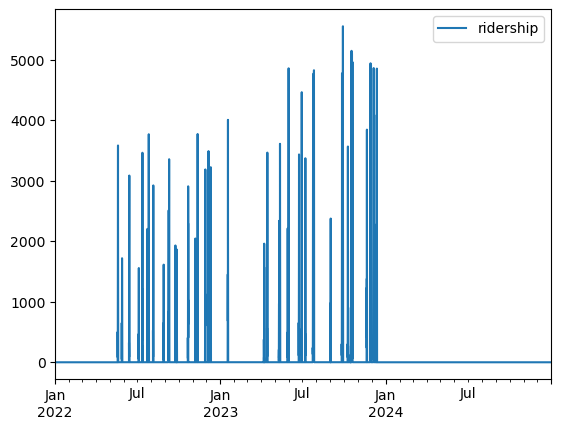

In [ ]:
local_reindex = pd.date_range(start=datetime(2022,1,1), end=datetime(2025,1,1), freq='h')[:-1]
pivoted_online_manhattan = manhattan_online_ridership.reset_index().pivot_table(index='transit_timestamp', columns='station_complex_id', values='ridership', aggfunc='sum').reindex(local_reindex)

station_complex_id = 618
df_i = manhattan_online_ridership[manhattan_online_ridership.station_complex_id == station_complex_id].sort_index()[['ridership']]
df_i.resample('h').sum().reindex(local_reindex).fillna(-1).plot()

# Others

/tmp/ipykernel_189990/2525398516.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  MTA_hourly_2020_2024 = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership__2020-2024_20250813.csv', index_col=0)
/tmp/ipykernel_189990/2525398516.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MTA_hourly_2020_2024.index = pd.to_datetime(MTA_hourly_2020_2024.index)


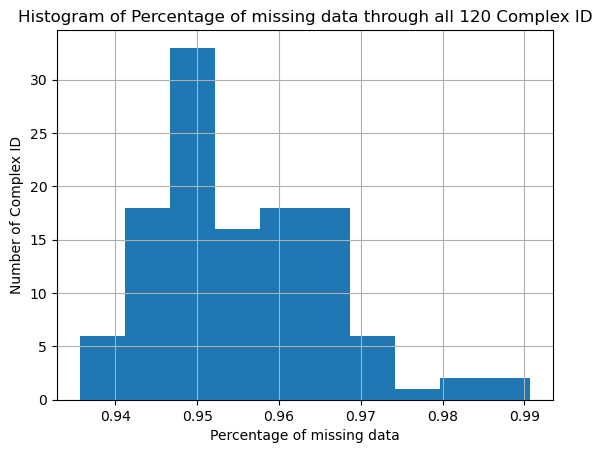

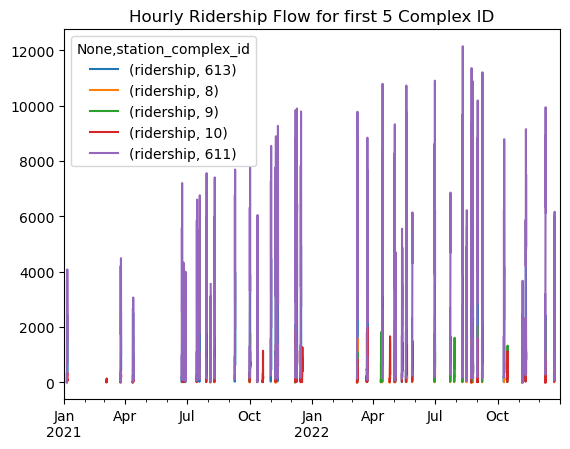

In [ ]:



# Aggregated complex_id hourly ridership data: 
grouped_hourly_complex_id = MTA_hourly_2021_2022.reset_index().groupby(['station_complex_id','transit_timestamp']).agg(latitude =('latitude', 'first'),
                                                                            longitude = ('longitude', 'first'),
                                                                            Georeference = ('Georeference', 'first'),
                                                                            ridership = ('ridership', 'sum'),
                                                                            transfers = ('transfers', 'sum')
                                                                            ).sort_index()

unique_complex_id = merged_gdf['Complex ID'].unique()
MTA_manhattan_hourly_flow = grouped_hourly_complex_id.loc[unique_complex_id][['ridership']].unstack(level=0).reindex(reindex)

# Visualize all the missing data 

# All the complex ID have more than 94% of missing data
import matplotlib.pyplot as plt
(MTA_manhattan_hourly_flow.isna().sum()/len(reindex)).hist()
plt.title(f'Histogram of Percentage of missing data through all {len(unique_complex_id)} Complex ID')
plt.xlabel('Percentage of missing data')
plt.ylabel('Number of Complex ID')
plt.show()
# Plot : 
MTA_manhattan_hourly_flow.iloc[:,:5].plot()
plt.title('Hourly Ridership Flow for first 5 Complex ID')
plt.show()

In [ ]:
reduced_df_subway_4h['datetime'] = reduced_df_subway_4h.apply(lambda row: pd.to_datetime(f"{row['date']} {row['time']}"), axis=1)
reduced_df_subway_4h = reduced_df_subway_4h.drop(columns=['date', 'time'])
reduced_df_subway_4h.groupby('Unit')

In [65]:
merged_gdf.explore(style_kwds={'radius': 10})

In [14]:
import os 
FOLDER_PATH = '../../../../data/rrochas/prediction_validation' 
NEMOB_DATA_FOLDER_PATH = f"{FOLDER_PATH}/../../NetMob/NetMob_raw"
apps = [app for app in os.listdir(NEMOB_DATA_FOLDER_PATH) if ((app != 'Lyon.geojson') and (not app.startswith('.'))) ] 
apps

['Apple_Video',
 'Google_Play_Store',
 'Google_Maps',
 'Web_Clothes',
 'Uber',
 'Twitter',
 'Microsoft_Mail',
 'Microsoft_Store',
 'Apple_Music',
 'Microsoft_Office',
 'Pokemon_GO',
 'Clash_of_Clans',
 'Yahoo_Mail',
 'PlayStation',
 'Wikipedia',
 'Apple_Web_Services',
 'Pinterest',
 'Web_Ads',
 'Google_Mail',
 'Google_Meet',
 'Apple_Siri',
 'Web_Adult',
 'Spotify',
 'Deezer',
 'Waze',
 'Web_Games',
 'Apple_App_Store',
 'Microsoft_Skydrive',
 'Google_Docs',
 'Microsoft_Web_Services',
 'Molotov',
 'YouTube',
 'Apple_iTunes',
 'Apple_iMessage',
 'DailyMotion',
 'Netflix',
 'Web_Transportation',
 'Web_Downloads',
 'SoundCloud',
 'TeamViewer',
 'Google_Web_Services',
 'Facebook',
 'EA_Games',
 'Tor',
 'Amazon_Web_Services',
 'Web_e-Commerce',
 'Telegram',
 'Apple_Mail',
 'Dropbox',
 'Web_Food',
 'Apple_iCloud',
 'Skype',
 'Facebook_Messenger',
 'Twitch',
 'Microsoft_Azure',
 'Instagram',
 'Facebook_Live',
 'Web_Streaming',
 'Orange_TV',
 'Periscope',
 'Snapchat',
 'Web_Finance',
 'WhatsApp'

/tmp/ipykernel_232069/3302529905.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds = [cm.get_cmap('Reds')(i) for i in np.linspace(0.2, 0.8, 5)]
/tmp/ipykernel_232069/3302529905.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = [cm.get_cmap('Blues')(i) for i in np.linspace(0.2, 0.8, 5)]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


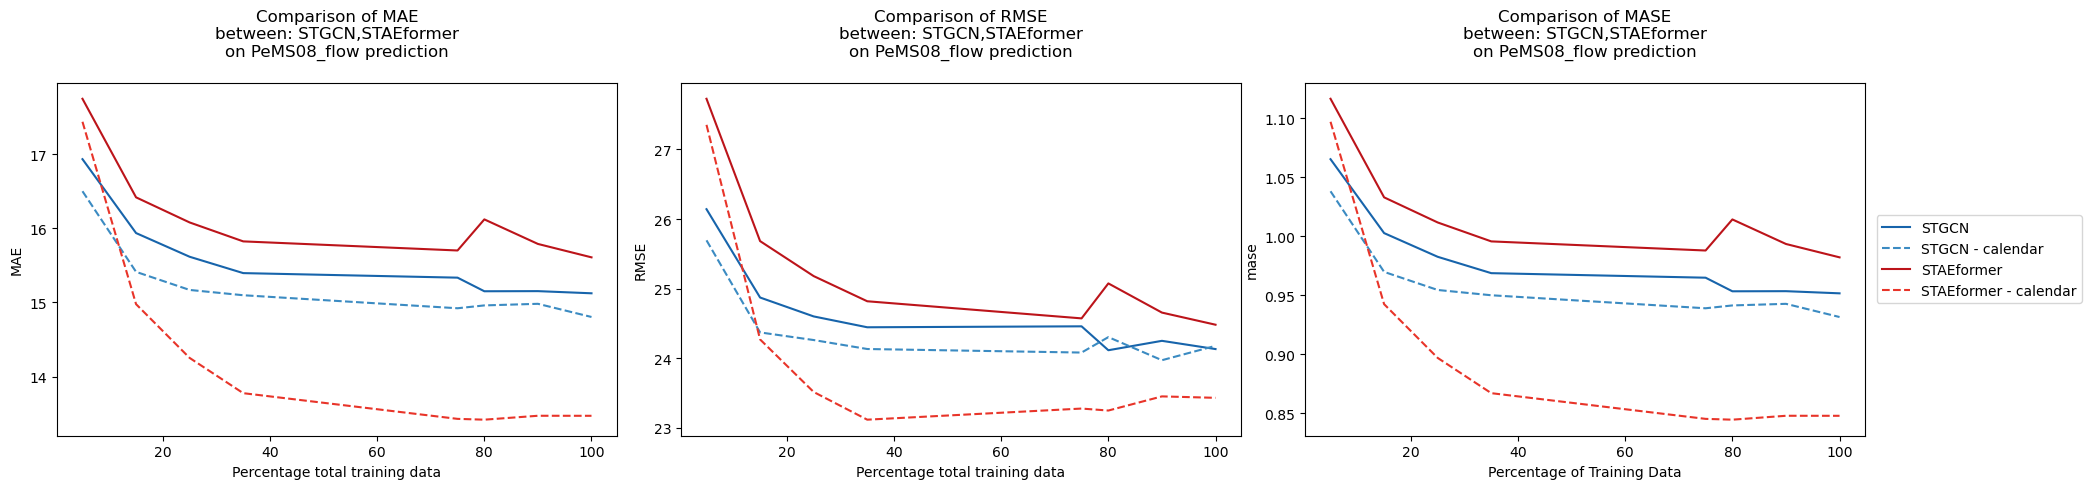

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


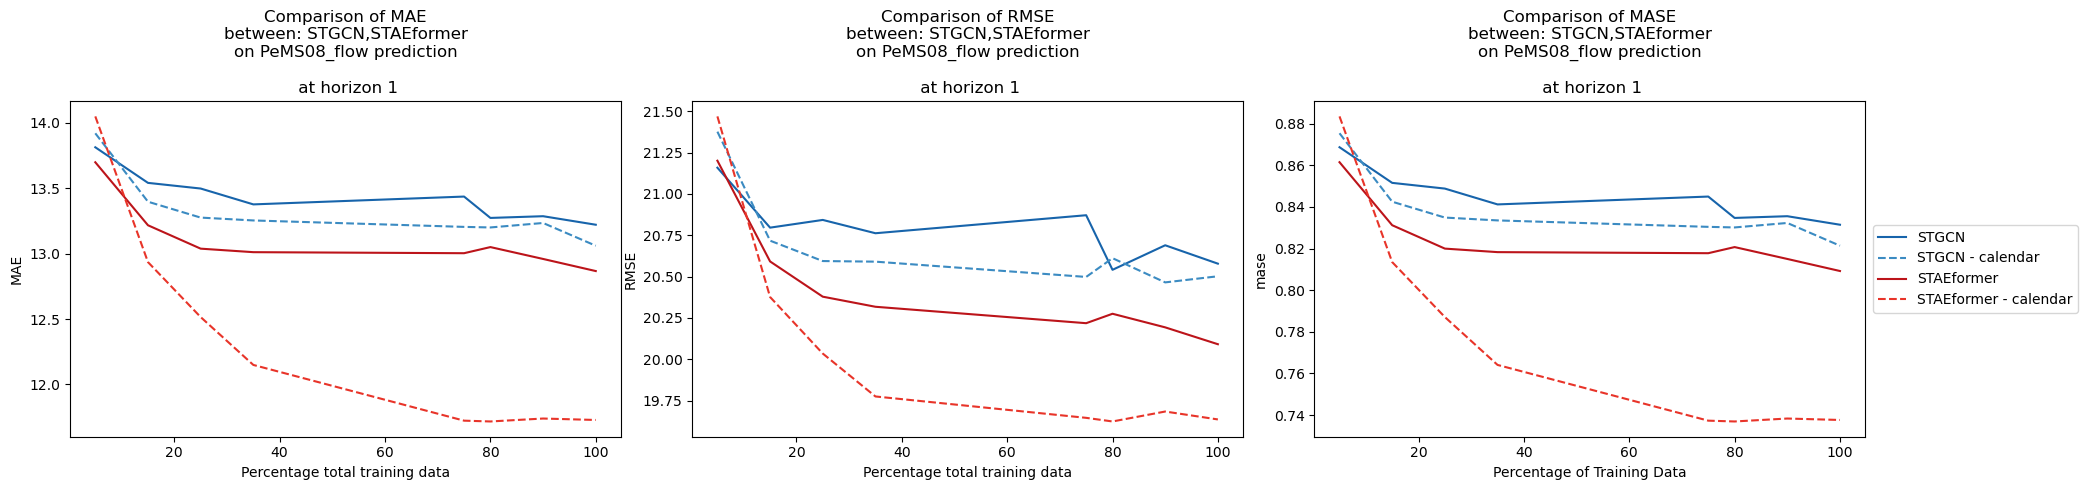

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


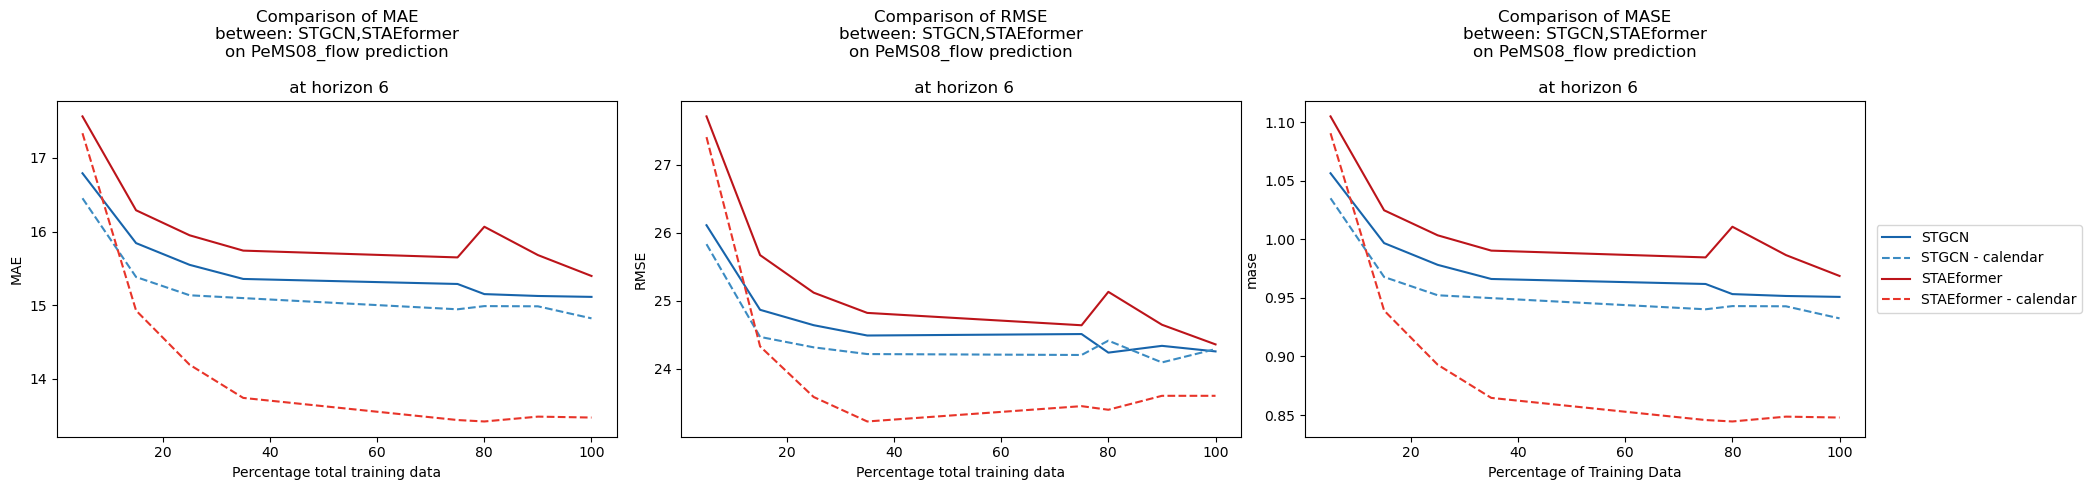

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


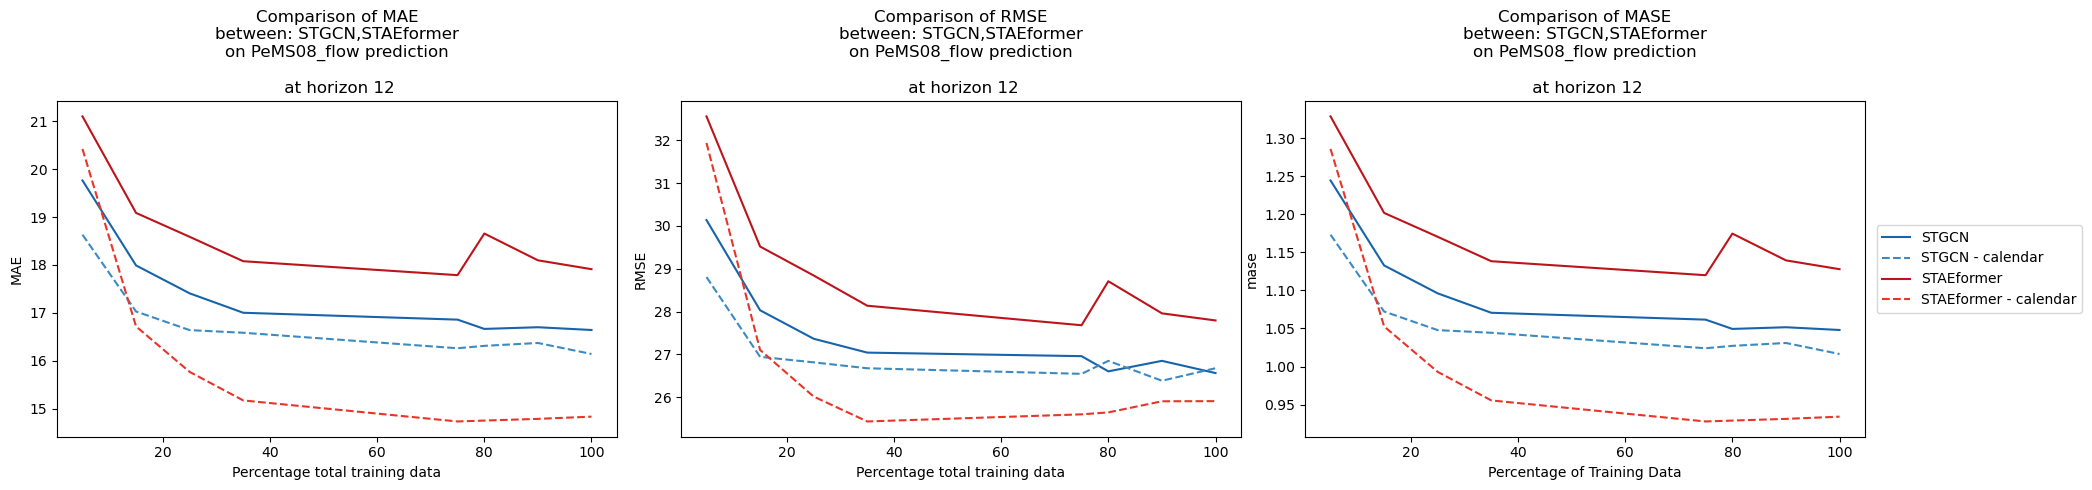

In [13]:
import matplotlib.cm as cm
reds = [cm.get_cmap('Reds')(i) for i in np.linspace(0.2, 0.8, 5)]
blues = [cm.get_cmap('Blues')(i) for i in np.linspace(0.2, 0.8, 5)]



# target_data  = 'subway_in'
target_data = 'PeMS08_flow'


metrics =['mae','rmse','mase'] #['mae','rmse','mape','mase']

if target_data == 'PeMS08_flow':
    dic_dataset_names = {'STAEformer':[['PeMS08_flow'],['PeMS08_flow','calendar']],
                        'STGCN':[['PeMS08_flow'], ['PeMS08_flow','calendar_embedding']]
                        }
    percentage_list = [5,15,25,35,75,80,90,100]  

    dic_colors = {'STAEformer':{'PeMS08_flow': reds[4],
                           'PeMS08_flow_calendar': reds[3]},
              'STGCN':{'PeMS08_flow': blues[4],
                       'PeMS08_flow_calendar_embedding': blues[3]}
             }      
    dic_linestyle = {'STAEformer':{'PeMS08_flow': '-',
                                'PeMS08_flow_calendar': '--'},
                    'STGCN':{'PeMS08_flow': '-',
                            'PeMS08_flow_calendar_embedding': '--'}
                    }  
    horizon_max = 12
    
if target_data == 'subway_in':
    dic_dataset_names = {'STAEformer':[['subway_in'],['subway_in','calendar'], ['subway_in','calendar','netmob_POIs']],
                        'STGCN':[['subway_in'], ['subway_in','calendar_embedding'],['subway_in', 'calendar_embedding','netmob_POIs']]
                        }
    percentage_list = [25,35,50,75,80,85,90,95,100]  
    # percentage_list = [50,75,80,85,90,95,100]# [10,15,25,35,50,75,80,85,90,95,100] # [25,35,50,75,80,85,90,95,100]  
    dic_colors = {'STAEformer':{'subway_in': reds[4],
                           'subway_in_calendar': reds[3],
                           'subway_in_calendar_netmob_POIs': reds[2]},
              'STGCN':{'subway_in': blues[4],
                       'subway_in_calendar_embedding': blues[3],
                       'subway_in_calendar_embedding_netmob_POIs': blues[2]}
             }      
    dic_linestyle = {'STAEformer':{'subway_in': '-',
                                'subway_in_calendar': '--',
                                'subway_in_calendar_netmob_POIs': ':'},
                    'STGCN':{'subway_in': '-',
                            'subway_in_calendar_embedding': '--',
                            'subway_in_calendar_embedding_netmob_POIs': ':'}
                    }   
    horizon_max = 4



model_names = ['STGCN','STAEformer']




# horizon_list = ['']

horizon_list = [''] + [f'_h{h}' for h in [1,horizon_max//2,horizon_max]]

plot_accuracy_according_size(model_names,dic_dataset_names,metrics,target_data,percentage_list,dic_colors,dic_linestyle,horizon_list = horizon_list)